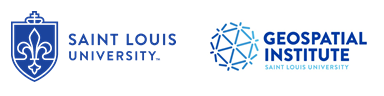

# Forest Conservation with AI
## - Part 1C: applying a U-Net model to imagery
* GIS 5092: Applied Machine Learning for GIS and Remote Sensing
* Saint Louis University, Fall 2021
* Instructor: Dr. Vasit Sagan

## Learning Objectives:

* Divide the whole image into smaller patches
* Appply model to smaller patches
* Merge the predicted labels together

# Nothing to Submit for this Notebook

---

In [ ]:
# Make project folder as current working directory
import os
print(os.getcwd())

Z:\gis5092-fall21\assignments\A8_forest_conservation_unet


---

In [ ]:
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import rasterio

In [ ]:
%%time
# Read the data image
src_data = rasterio.open('.\data\WV3_19Feb2019_BNR.tif')
img_data = src_data.read()
img_data_profile = src_data.profile

Wall time: 54.7 s


In [ ]:
# Move the channel axis to the right
img_data = np.moveaxis(img_data, 0, 2)

In [ ]:
img_data.shape

(8097, 8780, 16)

In [ ]:
# Define the patch size, number of bands, and classes
patch_size = 256
n_bands = 16
n_classes = 11

In [ ]:
# Get the total number of patches from the image
n_patches = math.ceil(img_data.shape[0]/patch_size) * math.ceil(img_data.shape[1]/patch_size)

In [ ]:
# Create an empty np array to store all the image as patches
image_patches = np.zeros((n_patches, patch_size, patch_size, n_bands), dtype=np.float32)

In [ ]:
image_patches.shape

(1120, 256, 256, 16)

In [ ]:
# Have a counter object to know how many iterations are going on
count = 0

for i in range(0, img_data.shape[0]+1, patch_size): # rows
    for j in range(0, img_data.shape[1]+1, patch_size): # cols
        # Create one image from the rows and cols
        img_patch = img_data[i:(i+patch_size), j:(j+patch_size), :]
        # Reshape the img_patch to add a n_samples channel to the first position
        image_patches[count, :img_patch.shape[0], :img_patch.shape[1], :] = img_patch
        
        count = count + 1      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

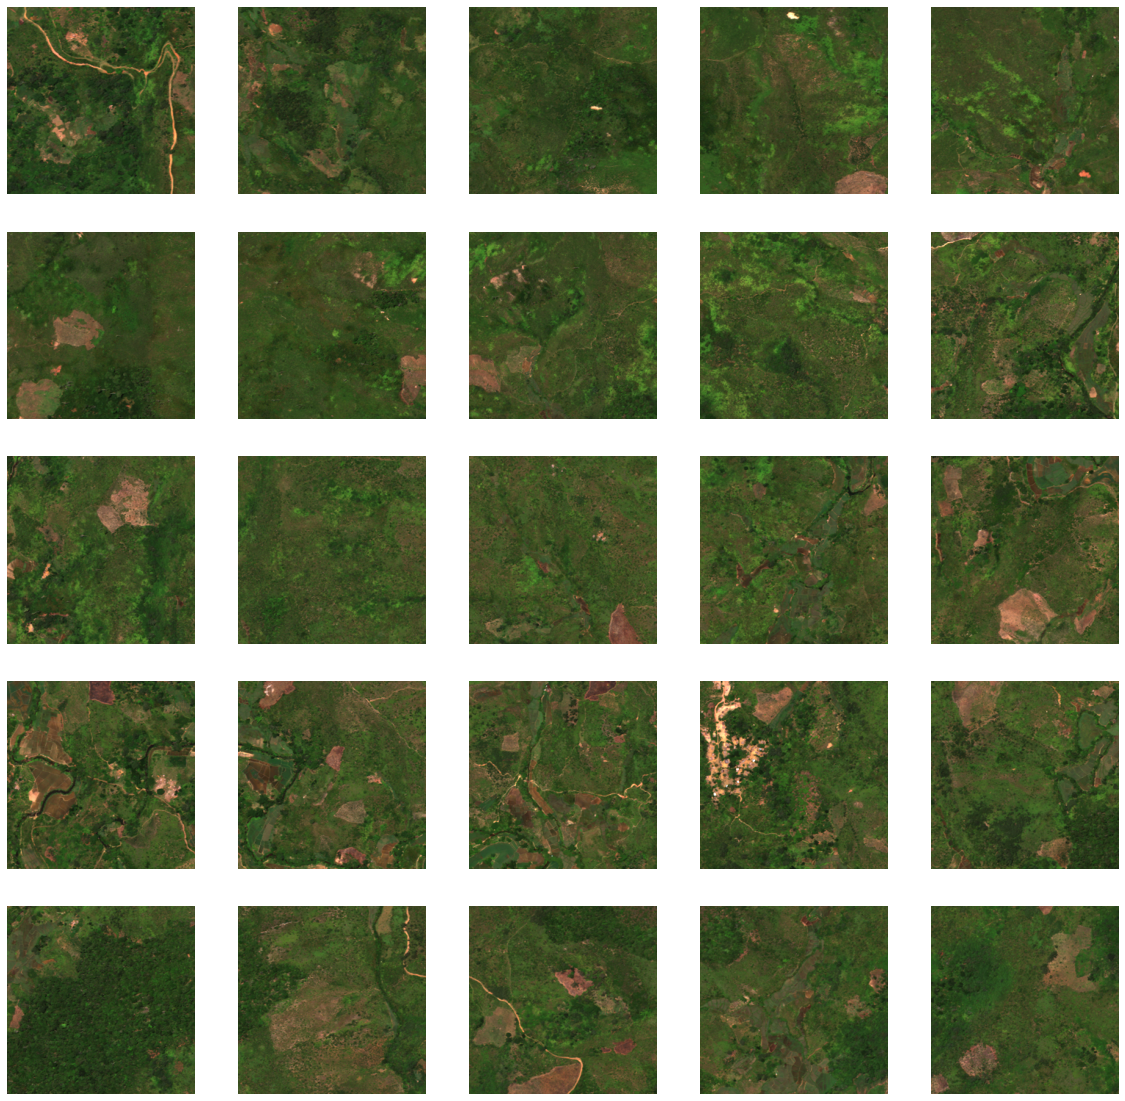

In [ ]:
# Visulizae some image patches

fig, ax = plt.subplots(5, 5, figsize=(20, 20))

count = 0

for i in range(5):
    for j in range(5):
        image = image_patches[count]
        image = np.dstack((image[:, :, 4], image[:, :, 2], image[:, :, 1]))
        ax[i,j].imshow(image * 4)
        ax[i,j].axis("off")
        
        count = count + 1
        
plt.show()

In [ ]:
# Load the model
model = load_model('unet.hdf5')

In [ ]:
# Create empty arrays to hold the predicted information
y_pred_all_1hot = np.zeros((n_patches, patch_size, patch_size, n_classes))

In [ ]:
for i in range(n_patches):
    # Get the sample image patch
    img = image_patches[i, :, :, :].reshape(1, patch_size, patch_size, n_bands)
    # Reshaping is necessary to define the first dimension as number of samples
    y_pred_all_1hot[i, :, :, :] = model.predict(img)
    
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [ ]:
# Revert back from 1hot to normal encoding
y_pred_all_series = np.argmax(y_pred_all_1hot, axis=-1)

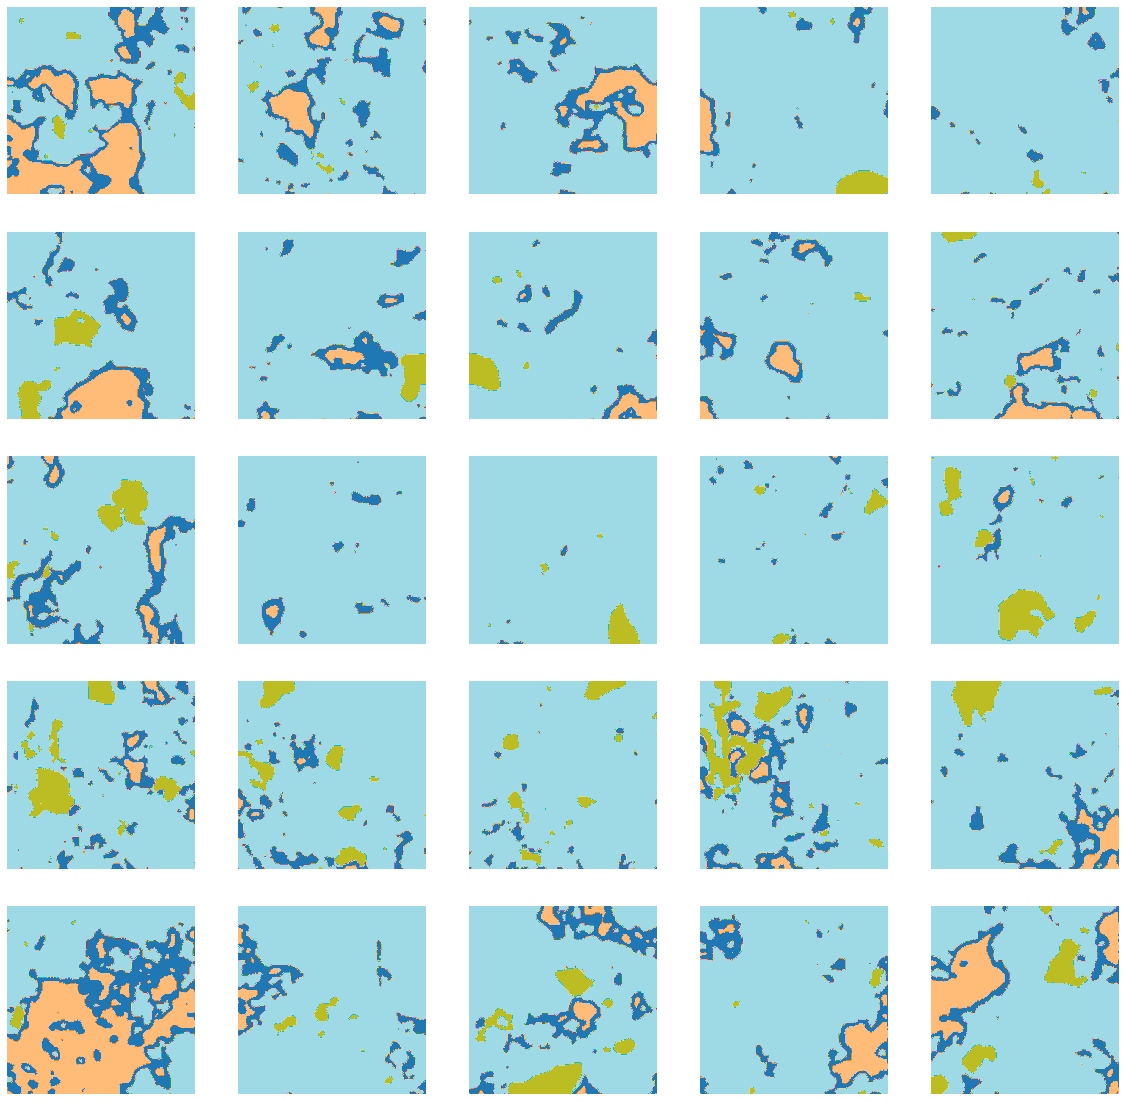

In [ ]:
# Visulizae some image patches

fig, ax = plt.subplots(5, 5, figsize=(20, 20))

count = 0

for i in range(5):
    for j in range(5):
        label = y_pred_all_series[count]
        ax[i,j].imshow(label, cmap='tab20')
        ax[i,j].axis("off")
        
        count = count + 1
        
plt.show()

In [ ]:
# Merge image patches into a 'label map'
h_patches = math.ceil(img_data.shape[0]/patch_size)
w_patches = math.ceil(img_data.shape[1]/patch_size)

label_map= np.zeros((patch_size*h_patches, patch_size*w_patches), dtype=np.float32)

count = 0

for i in range(0, img_data.shape[0]+1, 256) : 
  for j in range(0, img_data.shape[1]+1, 256):
    label_map[i:(i+patch_size), j:(j+patch_size)] = y_pred_all_series[count][:, :]
    
    count = count + 1

# Clipping off excess, if any
label_map= label_map[0:img_data.shape[0], 0:img_data.shape[1]]

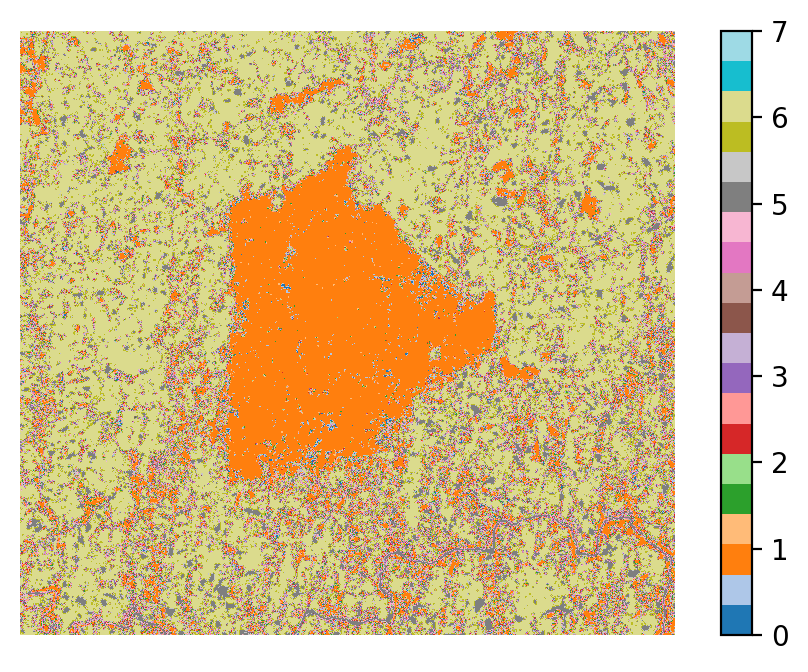

In [ ]:
# show label map
plt.figure(dpi=200)
plt.imshow(label_map, cmap='tab20')
plt.colorbar()
plt.axis("off")
plt.show()